# Tutorial: Ingest and query data from Apache Kafka

<!--
  ~ Licensed to the Apache Software Foundation (ASF) under one
  ~ or more contributor license agreements.  See the NOTICE file
  ~ distributed with this work for additional information
  ~ regarding copyright ownership.  The ASF licenses this file
  ~ to you under the Apache License, Version 2.0 (the
  ~ "License"); you may not use this file except in compliance
  ~ with the License.  You may obtain a copy of the License at
  ~
  ~   http://www.apache.org/licenses/LICENSE-2.0
  ~
  ~ Unless required by applicable law or agreed to in writing,
  ~ software distributed under the License is distributed on an
  ~ "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
  ~ KIND, either express or implied.  See the License for the
  ~ specific language governing permissions and limitations
  ~ under the License.
  -->

This tutorial introduces you to streaming ingestion in Apache Druid using the Apache Kafka event streaming platform.
Follow along to learn how to create and load data into a Kafka topic, start ingesting data from the topic into Druid, and query results over time. This tutorial assumes you have a basic understanding of Druid ingestion, querying, and API requests.

## Table of contents

* [Prerequisites](#Prerequisites)
* [Load Druid API client](#Load-Druid-API-client)
* [Create Kafka topic](#Create-Kafka-topic)
* [Load data into Kafka topic](#Load-data-into-Kafka-topic)
* [Start Druid ingestion](#Start-Druid-ingestion)
* [Query Druid datasource and visualize query results](#Query-Druid-datasource-and-visualize-query-results)
* [Learn more](#Learn-more)

## Prerequisites

Launch this tutorial and all prerequisites using the `all-services` profile of the Docker Compose file for Jupyter-based Druid tutorials. For more information, see [Docker for Jupyter Notebook tutorials](https://druid.apache.org/docs/latest/tutorials/tutorial-jupyter-docker.html).

Otherwise, you need the following:
* A running Druid instance.
   * Update the `druid_host` variable to point to your Router endpoint. For example, `druid_host = "http://localhost:8888"`.
* A running Kafka cluster.
   * Update the Kafka bootstrap servers to point to your servers. For example, `bootstrap_servers=["localhost:9092"]`.
* The following Python packages:
   * `druidapi`, a Python client for Apache Druid
   * `DruidDataDriver`, a data generator
   * `kafka`, a Python client for Apache Kafka
   * `pandas`, `matplotlib`, and `seaborn` for data visualization


## Load Druid API client

To start the tutorial, run the following cell. It imports the required Python packages and defines a variable for the Druid client, and another for the SQL client used to run SQL commands.

In [1]:
import druidapi
import json

# druid_host is the hostname and port for your Druid deployment. 
# In a distributed environment, you can point to other Druid services.
# In this tutorial, you'll use the Router service as the `druid_host`.
druid_host = "http://router:8888"

druid = druidapi.jupyter_client(druid_host)
display = druid.display
sql_client = druid.sql

# Create a rest client for native JSON ingestion for streaming data
rest_client = druidapi.rest.DruidRestClient("http://coordinator:8081")

## Create Kafka topic

This notebook relies on the Python client for the Apache Kafka. Import the Kafka producer and consumer modules, then create a Kafka client. You use the Kafka producer to create and publish records to a new topic named `social_media`.

In [2]:
from kafka import KafkaProducer
from kafka import KafkaConsumer

# Kafka runs on kafka:9092 in multi-container tutorial application
producer = KafkaProducer(bootstrap_servers='kafka:9092')
topic_name = "social_media"

Create the `social_media` topic and send a sample event. The `send()` command returns a metadata descriptor for the record.

In [3]:
event = {
    "__time": "2023-01-03T16:40:21.501",
    "username": "willow",
    "post_title": "This title is required",
    "views": 15284,
    "upvotes": 124,
    "comments": 21,
    "edited": "True"
}

producer.send(topic_name, json.dumps(event).encode('utf-8'))

To verify that the Kafka topic stored the event, create a consumer client to read records from the Kafka cluster, and get the next (only) message:

In [4]:
consumer = KafkaConsumer(topic_name, bootstrap_servers=['kafka:9092'], auto_offset_reset='earliest',
     enable_auto_commit=True)

print(next(consumer).value.decode('utf-8'))

{"__time": "2023-01-03T16:40:21.501", "username": "willow", "post_title": "This title is required", "views": 15284, "upvotes": 124, "comments": 21, "edited": "True"}


## Load data into Kafka topic

Instead of manually creating events to send to the Kafka topic, use a data generator to simulate a continuous data stream. This tutorial makes use of Druid Data Driver to simulate a continuous data stream into the `social_media` Kafka topic. To learn more about the Druid Data Driver, see the Druid Summit talk, [Generating Time centric Data for Apache Druid](https://www.youtube.com/watch?v=3zAOeLe3iAo).

In this notebook, you use a background process to continuously load data into the Kafka topic.
This allows you to keep executing commands in this notebook while data is constantly being streamed into the topic.

Run the following cells to load sample data into the `social_media` Kafka topic:

In [5]:
import multiprocessing as mp
from datetime import datetime
import DruidDataDriver

In [6]:
def run_driver():
    DruidDataDriver.simulate("kafka_docker_config.json", None, None, "REAL", datetime.now())
        
mp.set_start_method('fork')
ps = mp.Process(target=run_driver)
ps.start()

## Start Druid ingestion

Now that you have a new Kafka topic and data being streamed into the topic, you ingest the data into Druid by submitting a Kafka ingestion spec.
The ingestion spec describes the following:
* where to source the data to ingest (in `spec > ioConfig`),
* the datasource to ingest data into (in `spec > dataSchema > dataSource`), and
* what the data looks like (in `spec > dataSchema > dimensionsSpec`).

Other properties control how Druid aggregates and stores data. For more information, see the Druid documenation:
* [Apache Kafka ingestion](https://druid.apache.org/docs/latest/development/extensions-core/kafka-ingestion.html)
* [Ingestion spec reference](https://druid.apache.org/docs/latest/ingestion/ingestion-spec.html)

Run the following cells to define and view the Kafka ingestion spec.

In [7]:
kafka_ingestion_spec = "{\"type\": \"kafka\",\"spec\": {\"ioConfig\": {\"type\": \"kafka\",\"consumerProperties\": {\"bootstrap.servers\": \"kafka:9092\"},\"topic\": \"social_media\",\"inputFormat\": {\"type\": \"json\"},\"useEarliestOffset\": true},\"tuningConfig\": {\"type\": \"kafka\"},\"dataSchema\": {\"dataSource\": \"social_media\",\"timestampSpec\": {\"column\": \"__time\",\"format\": \"iso\"},\"dimensionsSpec\": {\"dimensions\": [\"username\",\"post_title\",{\"type\": \"long\",\"name\": \"views\"},{\"type\": \"long\",\"name\": \"upvotes\"},{\"type\": \"long\",\"name\": \"comments\"},\"edited\"]},\"granularitySpec\": {\"queryGranularity\": \"none\",\"rollup\": false,\"segmentGranularity\": \"hour\"}}}}"

In [8]:
print(json.dumps(json.loads(kafka_ingestion_spec), indent=4))

{
    "type": "kafka",
    "spec": {
        "ioConfig": {
            "type": "kafka",
            "consumerProperties": {
                "bootstrap.servers": "kafka:9092"
            },
            "topic": "social_media",
            "inputFormat": {
                "type": "json"
            },
            "useEarliestOffset": true
        },
        "tuningConfig": {
            "type": "kafka"
        },
        "dataSchema": {
            "dataSource": "social_media",
            "timestampSpec": {
                "column": "__time",
                "format": "iso"
            },
            "dimensionsSpec": {
                "dimensions": [
                    "username",
                    "post_title",
                    {
                        "type": "long",
                        "name": "views"
                    },
                    {
                        "type": "long",
                        "name": "upvotes"
                    },
                    {
 

Send the spec to Druid to start the streaming ingestion from Kafka:

In [9]:
headers = {
  'Content-Type': 'application/json'
}

rest_client.post("/druid/indexer/v1/supervisor", kafka_ingestion_spec, headers=headers)

<Response [200]>

A `200` response indicates that the request was successful. You can view the running ingestion task and the new datasource in the web console at http://localhost:8888/unified-console.html.

## Query Druid datasource and visualize query results

You can now query the new datasource called `social_media`. In this section, you also visualize query results using the Matplotlib and Seaborn visualization libraries. Run the following cell import these packages.

In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Run a simple query to view a subset of rows from the new datasource:

In [11]:
sql = '''
SELECT * FROM social_media LIMIT 5
'''
display.sql(sql)

__time,username,post_title,views,upvotes,comments,edited
2023-01-03T16:40:21.501Z,willow,This title is required,15284,124,21,True
2023-05-02T23:34:54.451Z,gus,3y4hkmd1!'Er4;,4031,93,15,False
2023-05-02T23:34:55.454Z,mia,"m62u53:D9s2bOvnY_VM9vjtZ'MyDLvQ7_xGodAP:ZNTXM6cFAt,_jrxBVBeRILLvAF9Z!jM9YNN;3ErV5eGbE_TFQS",16060,84,8,True
2023-05-02T23:34:55.455Z,jojo,"rAmeAJrjs;FBj:zy2MwoGh_P_SowlLTfp6zhX55xqogH.,1DC2xY_x2T;M_Vcu3QWaz650u;Roa",14313,65,7,False
2023-05-02T23:34:56.456Z,willow,"3bHB,iJdE;sedTDA,1dKGDAZL!qdsvO_tv.4Jrq7fa.KWcHPD'TB_5nnvsf9EgtnN8tGeeA0MjKc30iubJ:D'l7pHNihWpFz8K'46q!vJs",4237,112,3,True


In this social media scenario, each incoming event represents a post on social media, for which you collect the timestamp, username, and post metadata. You are interested in analyzing the total number of upvotes for all posts, compared between users. Preview this data with the following query:

In [12]:
sql = '''
SELECT
  COUNT(post_title) as num_posts,
  SUM(upvotes) as total_upvotes,
  username
FROM social_media
GROUP BY username
ORDER BY num_posts
'''

response = sql_client.sql_query(sql)
response.show()

num_posts,total_upvotes,username
155,10985,willow
161,11223,gus
164,11456,leon
173,12098,jojo
176,12175,mia
177,11998,milton
185,13256,miette
188,13360,rocket


Visualize the total number of upvotes per user using a line plot. You sort the results by username before plotting because the order of users may vary as new results arrive.

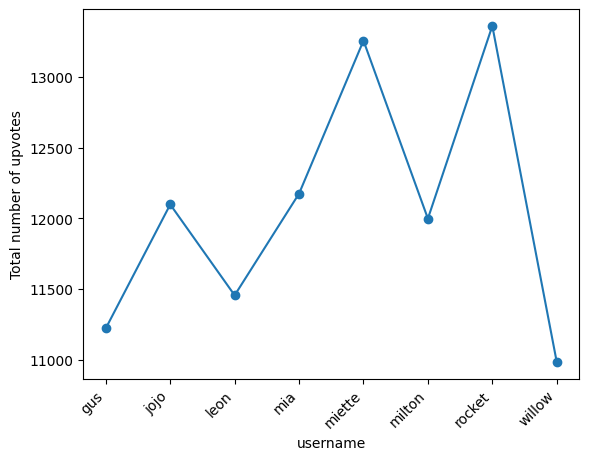

In [13]:
df = pd.DataFrame(response.json)
df = df.sort_values('username')

df.plot(x='username', y='total_upvotes', marker='o')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Total number of upvotes")
plt.gca().get_legend().remove()
plt.show()

The total number of upvotes likely depends on the total number of posts created per user. To better assess the relative impact per user, you compare the total number of upvotes (line plot) with the total number of posts.

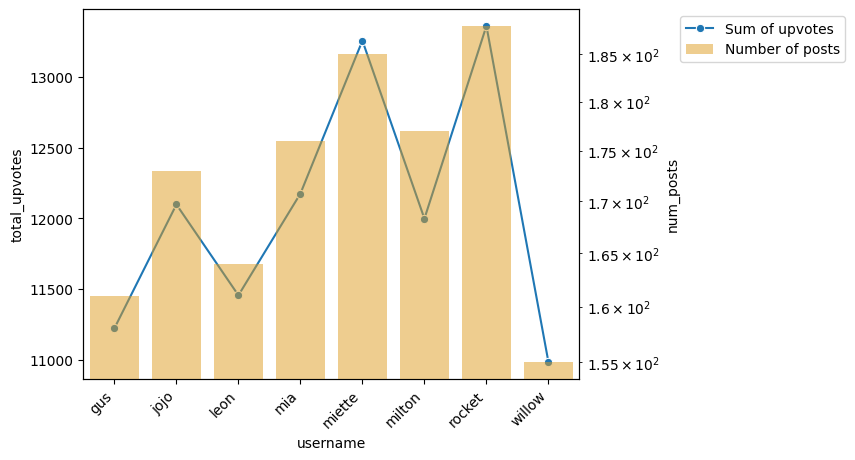

In [14]:
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots()
plt.xticks(rotation=45, ha='right')


sns.lineplot(
    data=df, x='username', y='total_upvotes',
    marker='o', ax=ax1, label="Sum of upvotes")
ax1.get_legend().remove()

ax2 = ax1.twinx()
sns.barplot(data=df, x='username', y='num_posts',
            order=df['username'], alpha=0.5, ax=ax2, log=True,
            color="orange", label="Number of posts")


# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, bbox_to_anchor=(1.55, 1))

You should see a correlation between total number of upvotes and total number of posts. In order to track user impact on a more equal footing, normalize the total number of upvotes relative to the total number of posts, and plot the result:

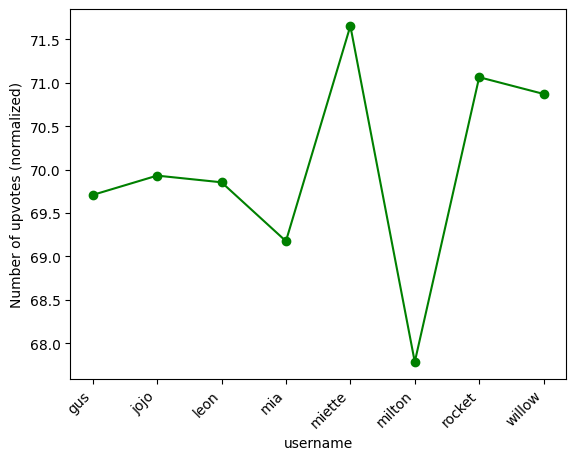

In [15]:
df['upvotes_normalized'] = df['total_upvotes']/df['num_posts']

df.plot(x='username', y='upvotes_normalized', marker='o', color='green')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of upvotes (normalized)")
plt.gca().get_legend().remove()
plt.show()

You've been working with data taken at a single snapshot in time from when you ran the last query. Run the same query again, and store the output in `response2`, which you will compare with the previous results:

In [16]:
response2 = sql_client.sql_query(sql)
response2.show()

num_posts,total_upvotes,username
404,28166,willow
418,29413,jojo
419,29202,mia
419,29456,miette
428,29472,gus
433,30160,milton
440,31212,leon
443,31063,rocket


Normalizing the data also helps you evaluate trends over time more consistently on the same plot axes. Plot the normalized data again, this time alongside the results from the previous snapshot:

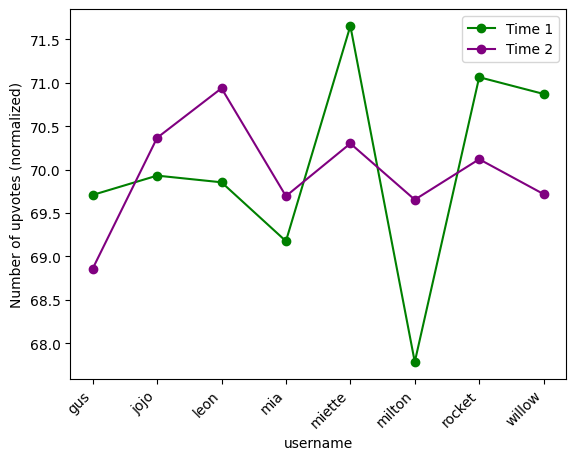

In [17]:
df2 = pd.DataFrame(response2.json)
df2 = df2.sort_values('username')
df2['upvotes_normalized'] = df2['total_upvotes']/df2['num_posts']

ax = df.plot(x='username', y='upvotes_normalized', marker='o', color='green', label="Time 1")
df2.plot(x='username', y='upvotes_normalized', marker='o', color='purple', ax=ax, label="Time 2")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of upvotes (normalized)")
plt.show()

This plot shows how some users maintain relatively consistent social media impact between the two query snapshots, whereas other users grow or decline in their influence.

## Learn more

This tutorial showed you how to create a Kafka topic using a Python client for Kafka, send a simulated stream of data to Kafka using a data generator, and query and visualize results over time. For more information, see the following resources:

* [Apache Kafka ingestion](https://druid.apache.org/docs/latest/development/extensions-core/kafka-ingestion.html)
* [Querying data](https://druid.apache.org/docs/latest/tutorials/tutorial-query.html)
* [Tutorial: Run with Docker](https://druid.apache.org/docs/latest/tutorials/docker.html)